# Bike Sharing Assignment

## Problem Statement

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
-  Which variables are significant in predicting the demand for shared bikes.
-  How well those variables describe the bike demands

## Step 1 : Reading, understanding and visualising data (EDA)


### Data Cleaning
-  Importing required libraries

In [53]:
# Importing Libraries for data manipulation
import numpy as np
import pandas as pd

# Importing Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Importing Libraries for buiding model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Warnings library will be used to ignore some warnings
import warnings
warnings.filterwarnings('ignore')

-  Reading daily bike demards dataset (csv file) and initializing dataframe

In [54]:
bike_df = pd.read_csv('day.csv')
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


Clearly, There are no null values in the data set.

-  Checking duplicate rows

In [55]:
bike_df.duplicated().sum()

0

-  Checking columns which contains single values only because such columns will not be helpful in the analysis.

In [56]:
bike_df.columns[bike_df.nunique() <= 1].shape

(0,)

-  Checking NA/Blank values

In [57]:
bike_df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

-  Deleting columns which is irrelevent.

<u>'instant'</u> - It is basically a index column which has no significance.<br>
<u>'dteday'</u> - We already have seperate columns for 'year' & 'month', hence we will not need this column.<br>
<u>'casual' & 'registered'</u> - our goal is to find the count of total rental bikes including both casual and registered not by specific category, hence we will ignore these two columns. 

In [58]:
bike_df.drop(['instant'],axis=1,inplace=True)
bike_df.drop(['dteday'],axis=1,inplace=True)
bike_df.drop(['casual'],axis=1,inplace=True)
bike_df.drop(['registered'],axis=1,inplace=True)
bike_df.shape

(730, 12)

-  Correcting data type and format of columns

Before creating dummy variables (for 'mnth', 'weekday', 'season' & 'weathersit'), we will have to convert them into 'category'

In [59]:
bike_df.season.replace({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"},inplace = True)
bike_df.weathersit.replace({1:'Clear',2:'Misty',3:'Light_RainSnow',4:'Heavy_RainSnow'},inplace = True)
bike_df.mnth = bike_df.mnth.replace({1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'})
bike_df.weekday = bike_df.weekday.replace({0: 'Sun',1: 'Mon',2: 'Tue',3: 'Wed',4: 'Thu',5: 'Fri',6: 'Sat'})

bike_df.season=bike_df.season.astype('category')
bike_df.weathersit=bike_df.weathersit.astype('category')
bike_df.mnth=bike_df.mnth.astype('category')
bike_df.weekday=bike_df.weekday.astype('category')
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    category
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    category
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(4), float64(4), int64(4)
memory usage: 49.7 KB


Renaming few columns for better readibility

In [60]:
bike_df.rename(columns={'yr':'year','mnth':'month','hum':'humidity','cnt':'count'}, inplace=True)

-  Checking outlier values in continuous columns ('temp', 'atemp', 'hum', 'windspeed') via box plot

In [61]:
# Creating list for each boxplot title
subplot_titles_list = [
    'Temperature',
    'fTemperature',
    'Humidity',
    'Wind Speed'
]

# Create subplots with 1 rows and 4 columns
fig = make_subplots(rows=1, cols=4, subplot_titles=subplot_titles_list)

# Add boxplots to each subplot
fig.add_trace(go.Box(y=bike_df.temp, name='Temperature'), row=1, col=1)
fig.add_trace(go.Box(y=bike_df.atemp, name='fTemperature'), row=1, col=2)
fig.add_trace(go.Box(y=bike_df.humidity, name='Humidity'), row=1, col=3)
fig.add_trace(go.Box(y=bike_df.windspeed, name='Wind Speed'), row=1, col=4)


# Update layout for better spacing
fig.update_layout(height=500, width=1000, title_text="Distribution of Continuous columns")

# Show the plot
fig.show()

In Temperature, fTemperature and Humidity, There are no outliers hence we can move ahead with analysis. <br>
In Wind Speed, Upper fence is 27.380948 and max is 34.000021 which is very near to upper fence hence we can move ahead with analysis because it will not have much impact on the analysis.

### EDA

#### Drawing pairplots to check for linear relationship

<Figure size 1500x3000 with 0 Axes>

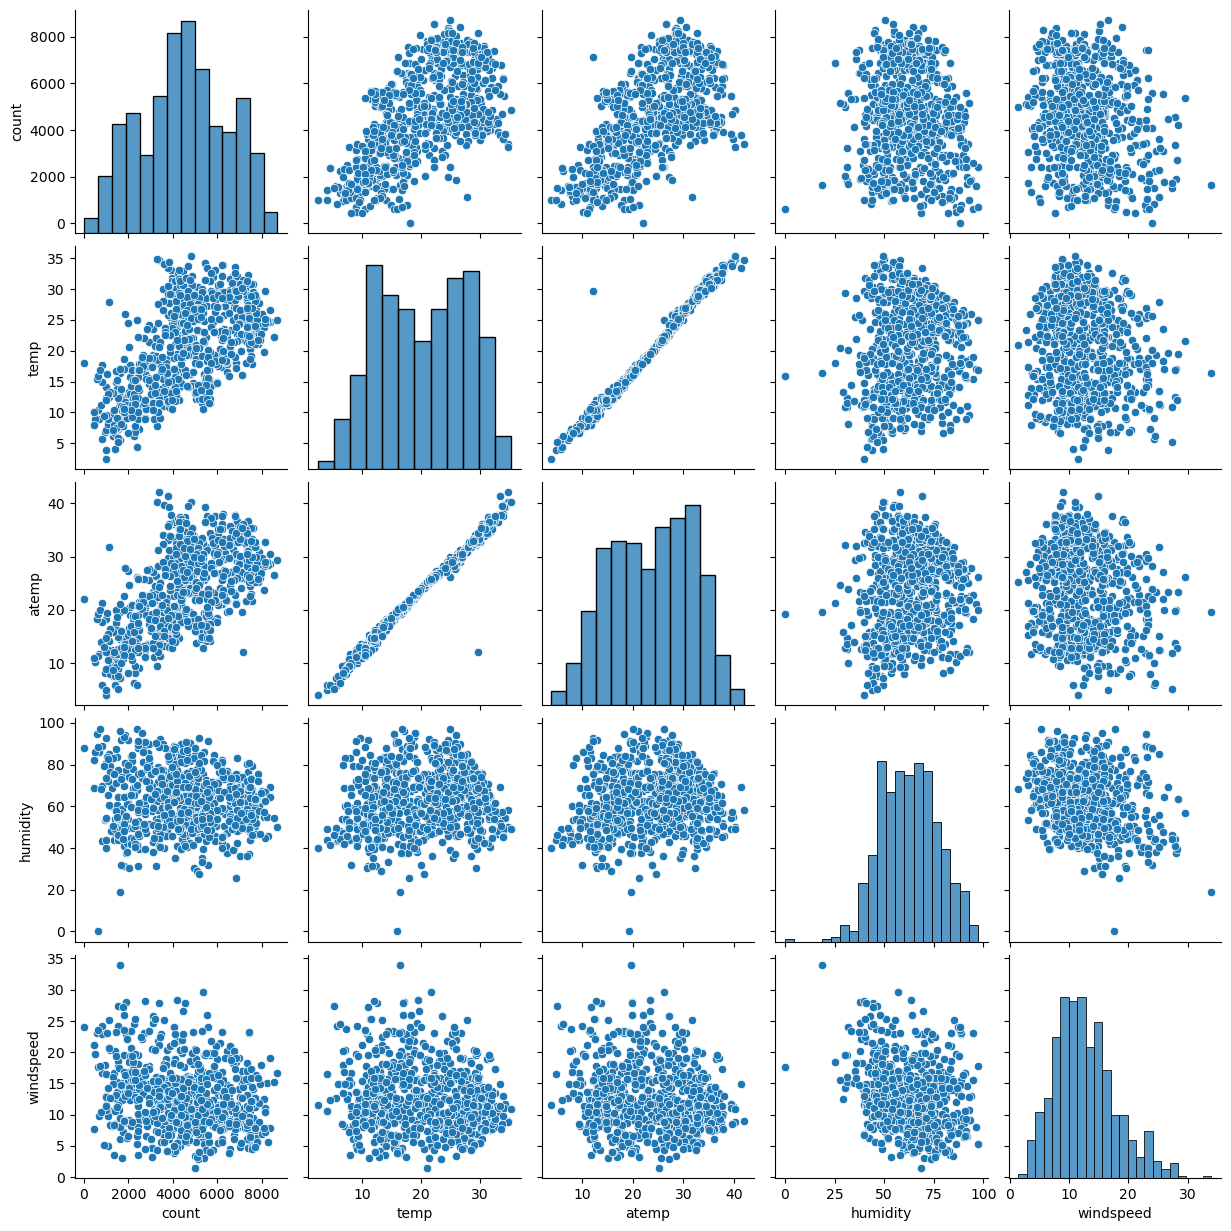

In [62]:
plt.figure(figsize = (15,30))
sns.pairplot(data=bike_df,vars=['count', 'temp', 'atemp', 'humidity','windspeed'])
plt.show()

### Analysis on categorical variables

Declaring functions to get statistical and graphical details of a categorical column against count

In [63]:
# function to get statistical details
def get_stats_against_count(col):
    cat_df = bike_df.groupby(col)['count'].agg(['sum', 'mean','count']).sort_values('sum',ascending = False)
    cat_df['sum_perc']=cat_df['sum']/bike_df['count'].sum()*100
    cat_df['count_perc']=cat_df['count']/bike_df['count'].count()*100
    cat_df = round(cat_df,2)
    print(cat_df)

#  function to get graphical details
def get_plots_against_count(col):
    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1)
    sns.barplot(data=bike_df, x=col, y='count')
    plt.subplot(1,2,2)
    sns.barplot(data=bike_df, x=col, y='count', hue='year',palette=['lightgreen', 'darkgreen'])
    plt.legend(labels=['2018', '2019'])
    plt.show()

- <b>Analyzing season against count</b>

            sum     mean  count  sum_perc  count_perc
season                                               
Fall    1061129  5644.30    188     32.24       25.75
Summer   918589  4992.33    184     27.91       25.21
Winter   841613  4728.16    178     25.57       24.38
Spring   469514  2608.41    180     14.27       24.66


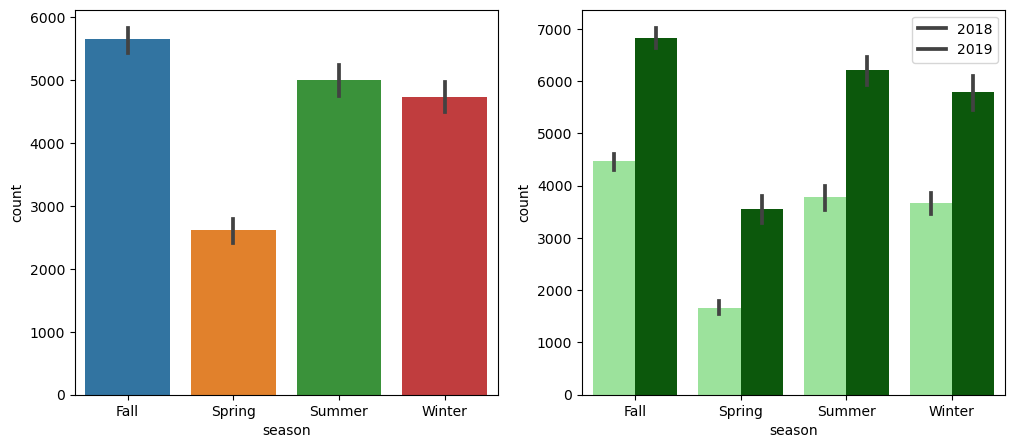

In [64]:
get_stats_against_count('season')
get_plots_against_count('season')

Observation : 
-  Around 32% of the bike booking happened in fall, followed by Summer & Winter with 28% & 26% of total booking respectively.
-  There has been a significant growth in demand during 2019 compared to 2018.

- <b>Analyzing month against count</b>

          sum     mean  count  sum_perc  count_perc
month                                              
Aug    351194  5664.42     62     10.67        8.49
Jun    346342  5772.37     60     10.52        8.22
Sept   345991  5766.52     60     10.51        8.22
Jul    344948  5563.68     62     10.48        8.49
May    331686  5349.77     62     10.08        8.49
Oct    322352  5199.23     62      9.80        8.49
Apr    269094  4484.90     60      8.18        8.22
Nov    254831  4247.18     60      7.74        8.22
Mar    228920  3692.26     62      6.96        8.49
Dec    211036  3403.81     62      6.41        8.49
Feb    149518  2669.96     56      4.54        7.67
Jan    134933  2176.34     62      4.10        8.49


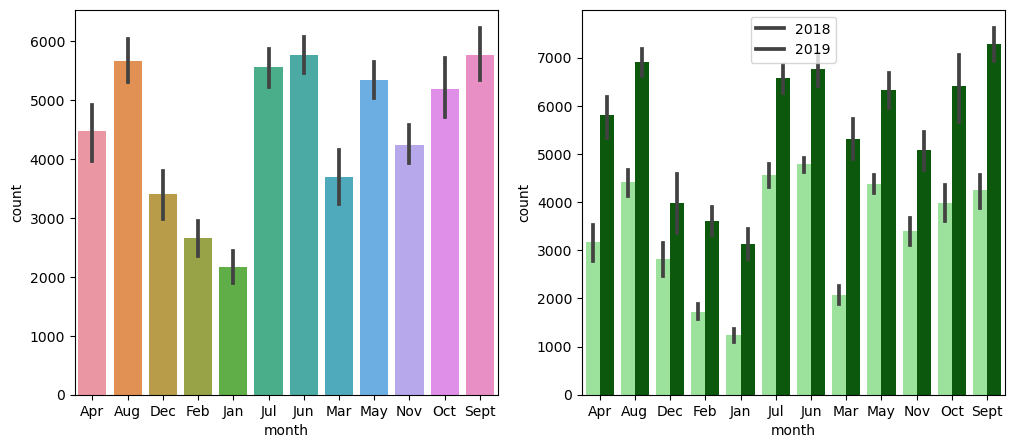

In [65]:
get_stats_against_count('month')
get_plots_against_count('month')

Observation : 
-  More than 10% of the bike booking happened in the months of May to Sep.
-  There has been a significant growth in demand during 2019 compared to 2018.

- <b>Analyzing weather situation against count</b>

                    sum     mean  count  sum_perc  count_perc
weathersit                                                   
Clear           2257952  4876.79    463     68.61       63.42
Misty            995024  4044.81    246     30.24       33.70
Light_RainSnow    37869  1803.29     21      1.15        2.88


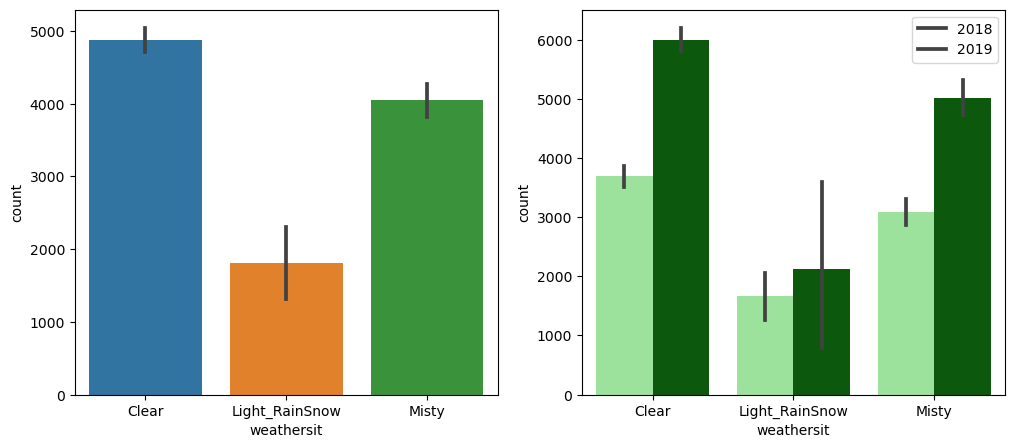

In [66]:
get_stats_against_count('weathersit')
get_plots_against_count('weathersit')

Observation : 
-  Around 67% bike booking happens during the Clear weather situation whereas Very few bookings (around 1%) happened during Light_RainSnow weather situation.
-  There has been a significant growth in demand during 2019 comapred to 2018.

- <b>Analyzing weekday against count</b>

            sum     mean  count  sum_perc  count_perc
weekday                                              
Fri      487790  4690.29    104     14.82       14.25
Thu      485395  4667.26    104     14.75       14.25
Sat      477807  4550.54    105     14.52       14.38
Wed      471214  4574.89    103     14.32       14.11
Tue      469109  4510.66    104     14.25       14.25
Mon      455503  4338.12    105     13.84       14.38
Sun      444027  4228.83    105     13.49       14.38


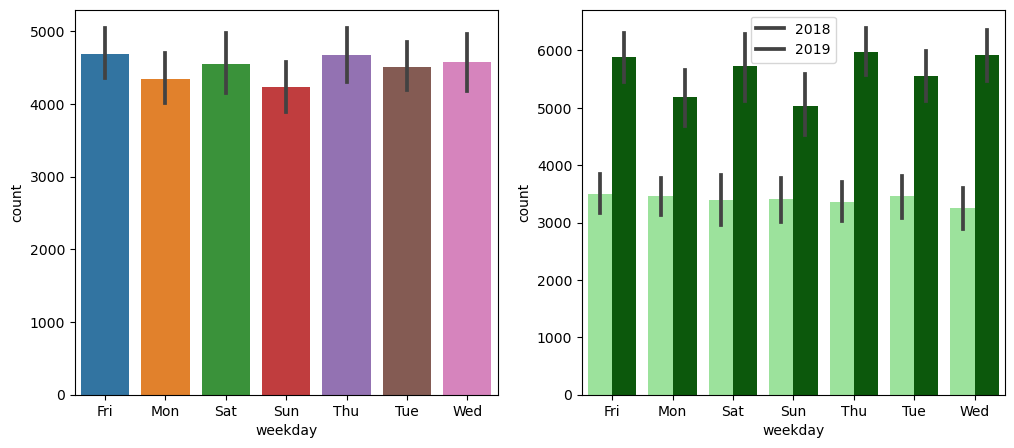

In [67]:
get_stats_against_count('weekday')
get_plots_against_count('weekday')

Observation :
-  Almost each day has around 14% of bike booking demand hence we can conclude that it is evenly distributed.
-  There has been a significant growth in demand during 2019 compared to 2018.

- <b>Analyzing workingday against count</b>

                sum     mean  count  sum_perc  count_perc
workingday                                               
1           2290576  4590.33    499      69.6       68.36
0           1000269  4330.17    231      30.4       31.64


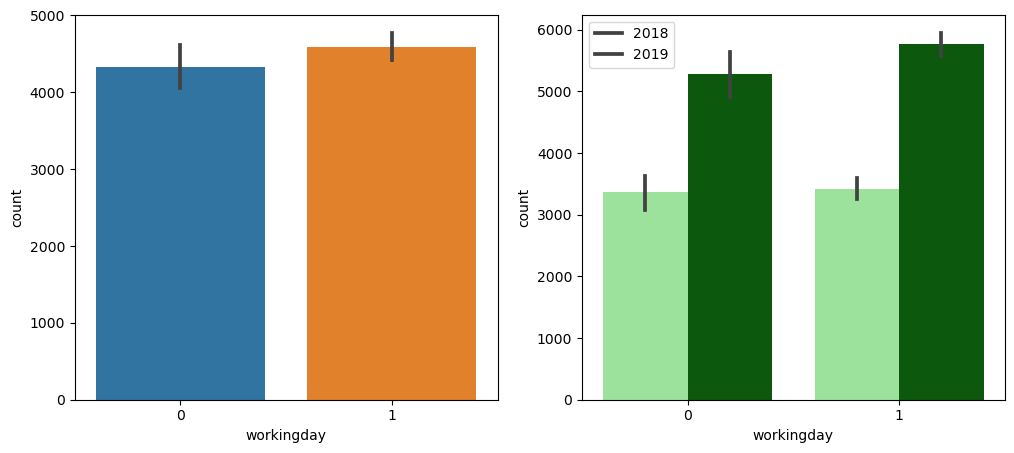

In [68]:
get_stats_against_count('workingday')
get_plots_against_count('workingday')

Observation :
-  Around 70% bike booking happens on the working day.
-  There has been a significant growth in demand during 2019 compared to 2018.

- <b>Analyzing holiday against count</b>

             sum    mean  count  sum_perc  count_perc
holiday                                              
0        3212410  4530.9    709     97.62       97.12
1          78435  3735.0     21      2.38        2.88


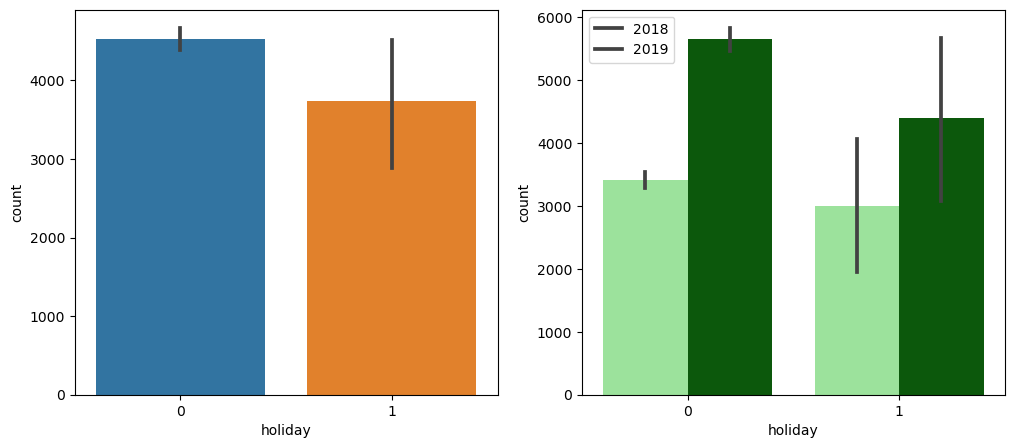

In [69]:
get_stats_against_count('holiday')
get_plots_against_count('holiday')

Observation :
-  Around 97% of bike bookings took place during non-holiday time.
-  There has been a significant growth in demand during 2019 compared to 2018.

### Analysis on continuous variables

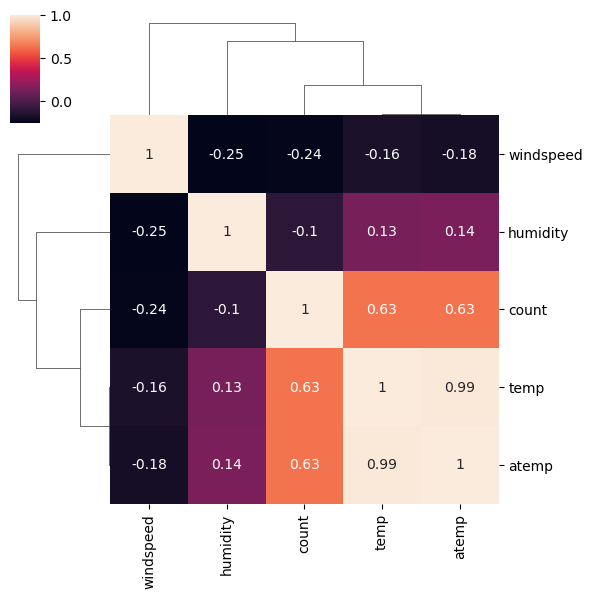

In [70]:
bike_continuous = ['temp','atemp','humidity','windspeed','count']
continuous_bike_df = bike_df[bike_continuous].corr().round(2)
sns.clustermap(continuous_bike_df,annot=True,figsize=(6,6))
plt.show()

Observation :
-  There is strong correlation between temp and atemp which means that there is linear relation between them.
-  There is good correlation between temp, atemp and count.

## Step 2 : Preparing data for modelling

### Creating dummy variables

In [71]:
# Get the dummy variables for the feature and store it in a new variables
# Also, Let's drop the first column from  new variables using 'drop_first = True'
season_dummies = pd.get_dummies(bike_df['season'], drop_first = True, dtype=int)
weathersit_dummies = pd.get_dummies(bike_df['weathersit'], drop_first = True, dtype=int)
month_dummies = pd.get_dummies(bike_df['month'], drop_first = True, dtype=int)
weekday_dummies = pd.get_dummies(bike_df['weekday'], drop_first = True, dtype=int)

# Add the results to the original housing dataframe
bike_df = pd.concat([bike_df, season_dummies, weathersit_dummies, month_dummies, weekday_dummies], axis = 1)

# Drop 'season','weathersit','month' and 'weekday' as we have created the dummies for it
bike_df.drop(['season','weathersit','month','weekday'], axis = 1, inplace = True)

#Checking data set
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            730 non-null    int64  
 1   holiday         730 non-null    int64  
 2   workingday      730 non-null    int64  
 3   temp            730 non-null    float64
 4   atemp           730 non-null    float64
 5   humidity        730 non-null    float64
 6   windspeed       730 non-null    float64
 7   count           730 non-null    int64  
 8   Spring          730 non-null    int32  
 9   Summer          730 non-null    int32  
 10  Winter          730 non-null    int32  
 11  Light_RainSnow  730 non-null    int32  
 12  Misty           730 non-null    int32  
 13  Aug             730 non-null    int32  
 14  Dec             730 non-null    int32  
 15  Feb             730 non-null    int32  
 16  Jan             730 non-null    int32  
 17  Jul             730 non-null    int

### Checking correlation matrix

Checking the correlation coefficients to see which variables are highly correlated.

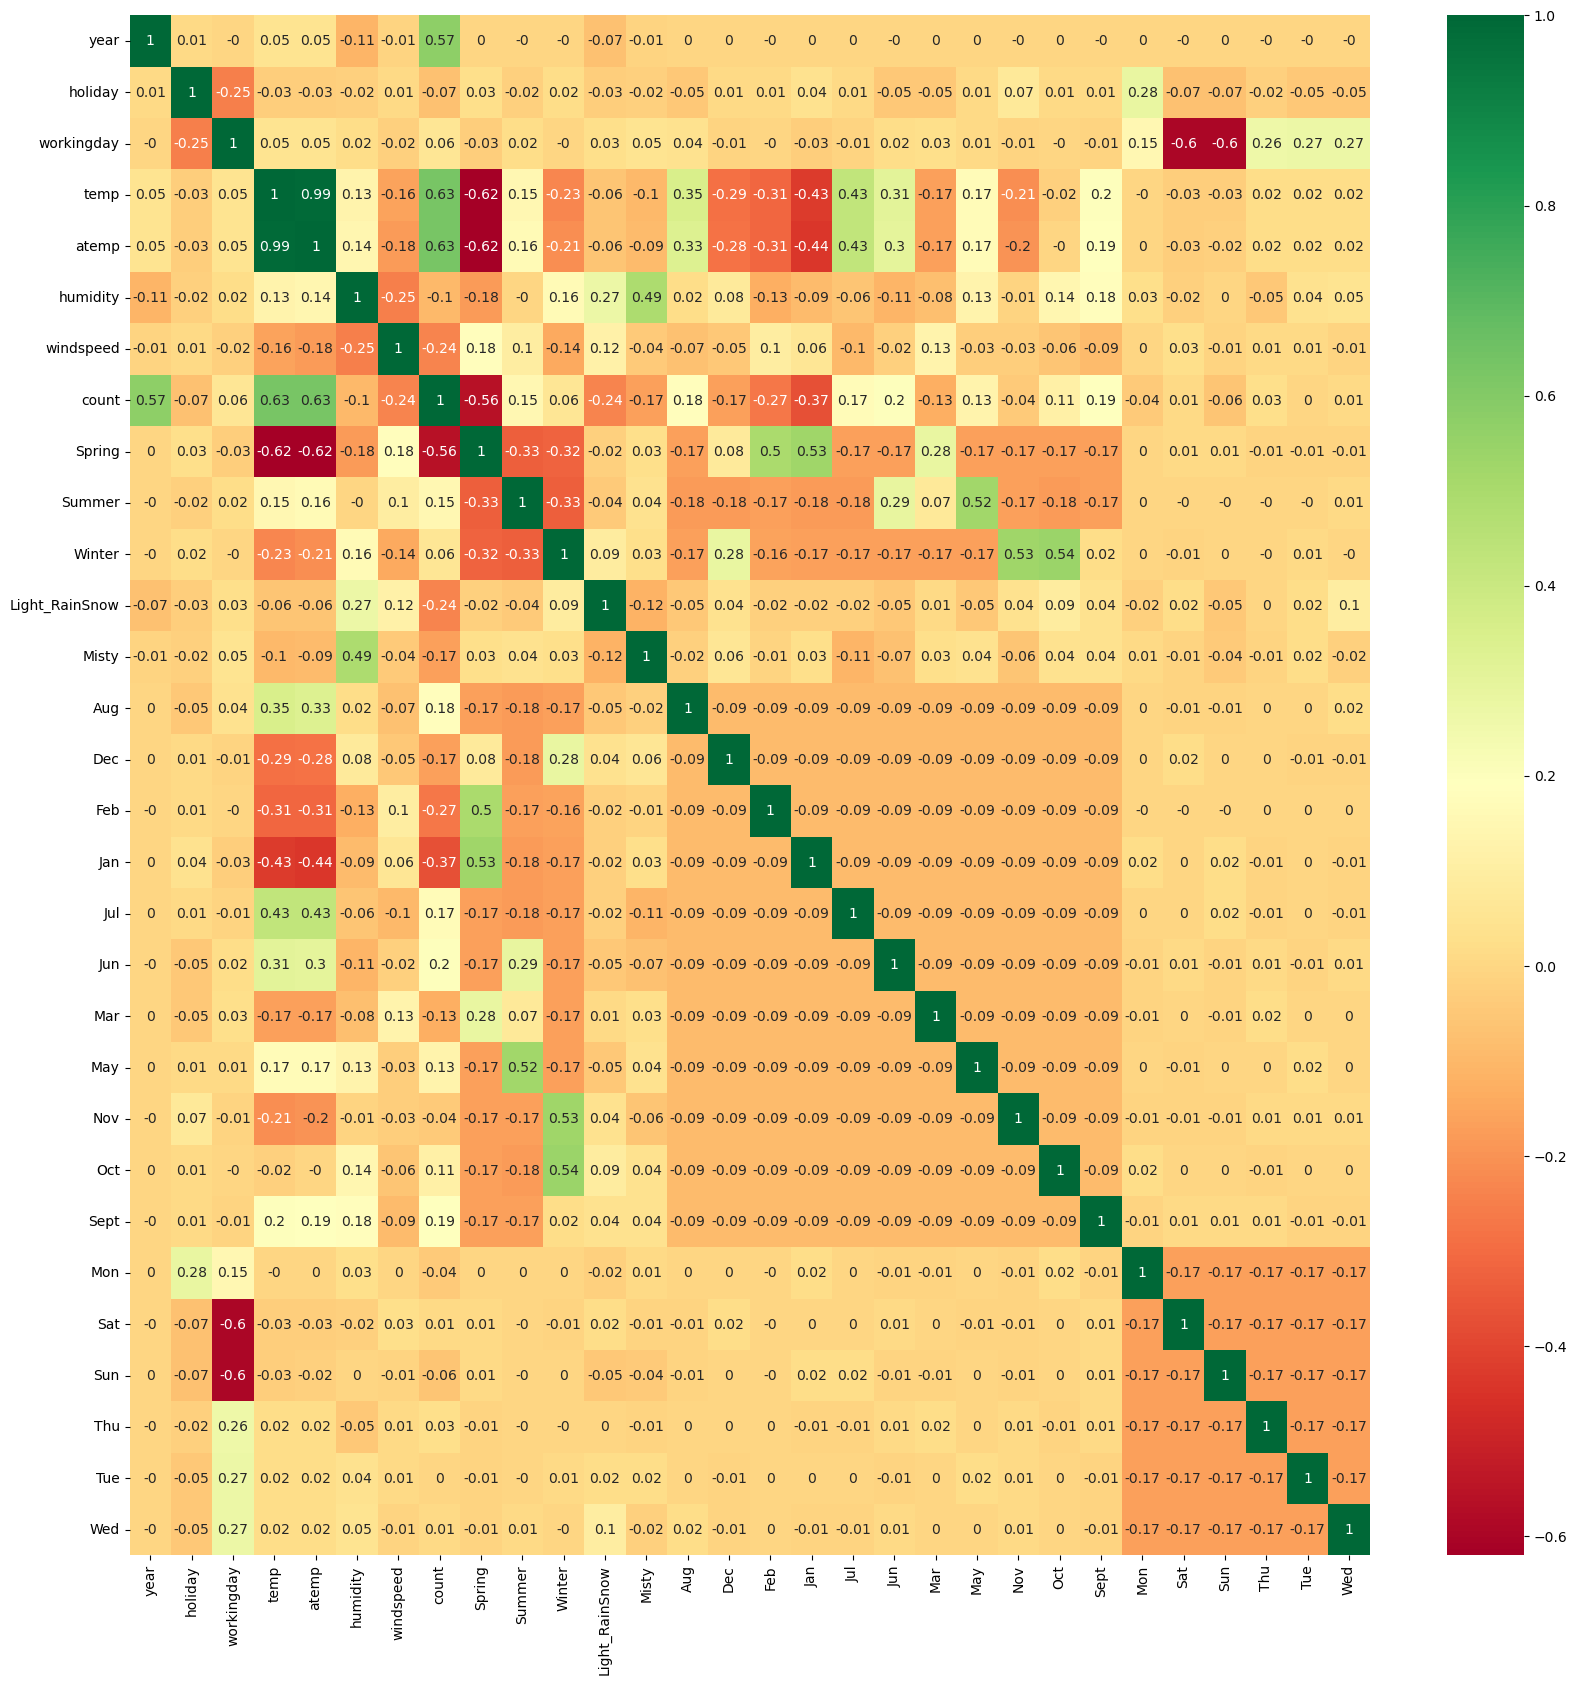

In [72]:
plt.figure(figsize=(20,20))
sns.heatmap(bike_df.corr().round(2),annot=True,cmap='RdYlGn')
plt.show()

Observation :
-  We can see multi-colinearity between the variables.
-  As temp or atemp are strongly correlated (0.99) which means there is high multicolinearity amongst the two hence we wil be using one of them.
-  count has strong correlation with temp(0.63), atemp(0.63) and year(0.57).
-  count is negatively correlated with Spring(-0.56).
-  humidity is postively correlated (0.49) to Misty weather and negatively correlated (-0.57) with Clear weather situation.

### Splitting Data into Train and Test data set

In [73]:
# Splitting the data using sklearn
# Due to train_test_split rounds up issue, i am passing a specific number of datapoints for train (70%) and test (30%) size.
bike_trainset_df, bike_testset_df = train_test_split(bike_df, train_size = 511, test_size = 219, random_state = 42)

# Checking shapes of train and test data set
print(bike_trainset_df.shape)
print(bike_testset_df.shape)

# Checking train data set stats
bike_trainset_df.describe()

(511, 30)
(219, 30)


,year,holiday,workingday,temp,atemp,humidity,windspeed,count,Spring,Summer,...,May,Nov,Oct,Sept,Mon,Sat,Sun,Thu,Tue,Wed
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,...,511.000000,511.000000,511.00000,511.00000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.520548,0.027397,0.669276,20.550310,24.009242,63.482145,12.598001,4552.951076,0.230920,0.258317,...,0.091977,0.091977,0.09002,0.09002,0.148728,0.150685,0.152642,0.146771,0.131115,0.140900
std,0.500067,0.163398,0.470935,7.476797,8.112525,13.939855,4.965253,1938.435496,0.421834,0.438138,...,0.289276,0.289276,0.28649,0.28649,0.356169,0.358092,0.359994,0.354224,0.337857,0.348259
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,431.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.079626,17.407600,52.848700,9.041918,3288.500000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,21.354153,25.410200,64.041700,11.791732,4590.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,26.940424,30.556050,73.458300,15.583497,6037.500000,0.000000,1.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.041700,28.250014,8714.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Rescaling the train dataframe

We are going to use MinMax rescaling the features (MinMax Scaling:x = x - xmin / xmax - xmin)

In [74]:
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp','atemp','humidity','windspeed','count']

# Calling fit_transform() menthod
bike_trainset_df[num_vars] = scaler.fit_transform(bike_trainset_df[num_vars])

# Checking results
bike_trainset_df[num_vars].head()

,temp,atemp,humidity,windspeed,count
683,0.327133,0.322150,0.639330,0.327101,0.605336
645,0.403972,0.404998,0.731215,0.419004,0.609320
163,0.717562,0.685963,0.509660,0.708724,0.554026
360,0.331287,0.326273,0.785745,0.415925,0.088253
640,0.745598,0.682653,0.817947,0.110593,0.862127


## Step 3 : Training the model

### Dividing into X and Y sets for the model building

In [75]:
y_train = bike_trainset_df.pop('count')
X_train = bike_trainset_df

### Recursive Feature Elimination

We will be using the LinearRegression function from SciKit Learn for its compatibility with RFE.

Running RFE with the output number of the variable equal to 20

In [76]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=20)             # running RFE
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('year', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('humidity', True, 1),
 ('windspeed', True, 1),
 ('Spring', True, 1),
 ('Summer', False, 6),
 ('Winter', True, 1),
 ('Light_RainSnow', True, 1),
 ('Misty', True, 1),
 ('Aug', True, 1),
 ('Dec', True, 1),
 ('Feb', False, 4),
 ('Jan', False, 8),
 ('Jul', True, 1),
 ('Jun', False, 9),
 ('Mar', True, 1),
 ('May', True, 1),
 ('Nov', True, 1),
 ('Oct', False, 7),
 ('Sept', True, 1),
 ('Mon', False, 3),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thu', False, 10),
 ('Tue', False, 2),
 ('Wed', False, 5)]

According to RFE, useful columns

In [77]:
ref_support_col = X_train.columns[rfe.support_]
ref_support_col

Index(['year', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'Spring', 'Winter', 'Light_RainSnow', 'Misty', 'Aug',
       'Dec', 'Jul', 'Mar', 'May', 'Nov', 'Sept', 'Sat', 'Sun'],
      dtype='object')

According to RFE, non useful columns

In [78]:
X_train.columns[~rfe.support_]

Index(['Summer', 'Feb', 'Jan', 'Jun', 'Oct', 'Mon', 'Thu', 'Tue', 'Wed'], dtype='object')

### Building model using statsmodel

Note - below are the thresholds for p-value and VIF
- VIF value <= 5
- p-value < 0.05

Declaring functions to get statsmodel and calculate VIF

In [79]:
def calculate_VIF(df):
    # create a new dataframe
    vif = pd.DataFrame()
    # add features columns
    vif['Features'] = df.columns
    # calculate VIF value for each feature
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    # round off VIF values
    vif['VIF'] = round(vif['VIF'], 2)
    # sort VIF values in decending order
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

def get_train_statsmodel(df):
    # Add a constant
    X_train_sm  = sm.add_constant(df)
    #Create a model
    lr = sm.OLS(y_train,X_train_sm)
    # Call fit to learn from data
    lr_model = lr.fit()
    print(lr_model.summary())

##### Model 1

In [80]:
# Creating model with RFE supported features
X_train_rfe = X_train[ref_support_col]
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features     VIF
3             temp  183.01
4            atemp  180.84
2       workingday   51.99
19             Sun   12.60
18             Sat   12.22
1          holiday    3.08
7           Spring    3.07
8           Winter    2.46
5         humidity    1.93
16             Nov    1.74
13             Jul    1.73
10           Misty    1.60
11             Aug    1.50
15             May    1.38
9   Light_RainSnow    1.34
17            Sept    1.34
6        windspeed    1.31
12             Dec    1.29
14             Mar    1.15
0             year    1.04
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     142.2
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          1.13e-185
Time:                        02:35:03 

##### Model 2

In [81]:
# dropping 'holiday' as it has high p and VIF values
X_train_rfe = X_train_rfe.drop(['holiday'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features      VIF
3            atemp  1284.34
2             temp  1260.58
4         humidity    30.80
1       workingday    17.97
5        windspeed     6.46
18             Sun     4.84
17             Sat     4.72
6           Spring     3.16
7           Winter     3.15
9            Misty     2.32
0             year     2.11
12             Jul     1.89
15             Nov     1.85
10             Aug     1.61
14             May     1.52
16            Sept     1.46
11             Dec     1.38
8   Light_RainSnow     1.33
13             Mar     1.22
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     142.2
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          1.13e-185
Time:                        02:35:03   Log-L

##### Model 3 

In [82]:
# Dropping 'temp' as it has High p-value and low VIF
X_train_rfe = X_train_rfe.drop(['temp'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features    VIF
3         humidity  30.51
2            atemp  22.49
1       workingday  17.87
4        windspeed   5.94
17             Sun   4.81
16             Sat   4.70
5           Spring   3.16
6           Winter   3.13
8            Misty   2.31
0             year   2.11
11             Jul   1.86
14             Nov   1.85
9              Aug   1.54
13             May   1.52
15            Sept   1.43
10             Dec   1.38
7   Light_RainSnow   1.31
12             Mar   1.21
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     150.3
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          1.10e-186
Time:                        02:35:03   Log-Likelihood:                 495.78
No. Observations:               

##### Model 4

In [83]:
# Dropping 'Aug' as it has High p-value and low VIF
X_train_rfe = X_train_rfe.drop(['Aug'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features    VIF
3         humidity  30.51
2            atemp  20.43
1       workingday  17.86
4        windspeed   5.89
16             Sun   4.81
15             Sat   4.70
5           Spring   3.14
6           Winter   2.97
8            Misty   2.30
0             year   2.11
13             Nov   1.85
10             Jul   1.57
9              Dec   1.37
12             May   1.36
7   Light_RainSnow   1.31
14            Sept   1.30
11             Mar   1.20
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     159.1
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          1.33e-187
Time:                        02:35:03   Log-Likelihood:                 495.32
No. Observations:                 511   AIC:              

##### Model 5

In [84]:
# Dropping 'Sun' as it has High p-value and low VIF
X_train_rfe = X_train_rfe.drop(['Sun'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features    VIF
3         humidity  26.21
2            atemp  18.55
4        windspeed   5.10
1       workingday   4.60
5           Spring   2.92
6           Winter   2.90
8            Misty   2.26
0             year   2.10
13             Nov   1.84
15             Sat   1.79
10             Jul   1.57
9              Dec   1.37
12             May   1.36
14            Sept   1.30
7   Light_RainSnow   1.29
11             Mar   1.19
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     168.7
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          2.55e-188
Time:                        02:35:03   Log-Likelihood:                 494.35
No. Observations:                 511   AIC:                            -954.7
Df Re

##### Model 6

In [85]:
# Dropping 'humidity' as it has High p-value and low VIF
X_train_rfe = X_train_rfe.drop(['humidity'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features   VIF
2            atemp  8.01
3        windspeed  5.06
1       workingday  4.53
5           Winter  2.51
0             year  2.09
4           Spring  1.95
12             Nov  1.80
14             Sat  1.76
7            Misty  1.59
9              Jul  1.55
8              Dec  1.33
11             May  1.32
13            Sept  1.29
10             Mar  1.19
6   Light_RainSnow  1.11
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     172.5
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          1.72e-185
Time:                        02:35:03   Log-Likelihood:                 484.89
No. Observations:                 511   AIC:                            -937.8
Df Residuals:                     495   BIC:   

##### Model 7

In [86]:
# Dropping 'May' as it has Low p-value and High VIF
X_train_rfe = X_train_rfe.drop(['May'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features   VIF
2            atemp  7.66
3        windspeed  5.06
1       workingday  4.52
5           Winter  2.41
0             year  2.09
4           Spring  1.90
11             Nov  1.80
13             Sat  1.76
7            Misty  1.58
9              Jul  1.45
8              Dec  1.33
12            Sept  1.23
10             Mar  1.18
6   Light_RainSnow  1.11
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     184.0
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          4.73e-186
Time:                        02:35:04   Log-Likelihood:                 483.50
No. Observations:                 511   AIC:                            -937.0
Df Residuals:                     496   BIC:                            

##### Model 8

In [87]:
# Dropping 'atemp' as it has Low p-value and High VIF
X_train_rfe = X_train_rfe.drop(['atemp'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features   VIF
2        windspeed  3.92
1       workingday  3.17
4           Winter  2.41
0             year  1.98
10             Nov  1.77
3           Spring  1.64
6            Misty  1.56
12             Sat  1.53
7              Dec  1.32
8              Jul  1.18
9              Mar  1.18
11            Sept  1.16
5   Light_RainSnow  1.10
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     147.3
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          5.20e-161
Time:                        02:35:04   Log-Likelihood:                 421.17
No. Observations:                 511   AIC:                            -814.3
Df Residuals:                     497   BIC:                            -755.0
Df Model:         

##### Model 9

In [88]:
# Dropping 'Jul' as it has Low p-value and High VIF
X_train_rfe = X_train_rfe.drop(['Jul'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features   VIF
2        windspeed  3.89
1       workingday  3.08
4           Winter  2.36
0             year  1.95
9              Nov  1.77
3           Spring  1.59
6            Misty  1.56
11             Sat  1.51
7              Dec  1.32
8              Mar  1.17
10            Sept  1.14
5   Light_RainSnow  1.10
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     159.1
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          1.04e-161
Time:                        02:35:04   Log-Likelihood:                 420.18
No. Observations:                 511   AIC:                            -814.4
Df Residuals:                     498   BIC:                            -759.3
Df Model:                          12      

##### Model 10

In [89]:
# Dropping 'Winter' as it has Low p-value and High VIF
X_train_rfe = X_train_rfe.drop(['Winter'], axis = 1)
calculate_VIF(X_train_rfe)
get_train_statsmodel(X_train_rfe)

          Features   VIF
2        windspeed  3.88
1       workingday  3.03
0             year  1.93
5            Misty  1.54
10             Sat  1.51
3           Spring  1.49
7              Mar  1.17
6              Dec  1.14
8              Nov  1.14
9             Sept  1.14
4   Light_RainSnow  1.09
                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     172.6
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          3.48e-162
Time:                        02:35:04   Log-Likelihood:                 418.64
No. Observations:                 511   AIC:                            -813.3
Df Residuals:                     499   BIC:                            -762.4
Df Model:                          11                               

This model looks good because:
- Here VIF is less than 5, indicates a low correlation of that predictor with other predictors.
- p-value for all the features is almost 0.0 which means predictors seems to be significant.
- Prob (F-statistic) is 3.48e-162 which means overall model fit is significant.
- R2 is 0.79 means that the predictors explain about 79% of the variation in our response variable.

### Final Model

In [90]:
final_lr_columns = X_train_rfe.columns
X_train_rfe  = sm.add_constant(X_train_rfe)
final_lr = sm.OLS(y_train,X_train_rfe)
final_lr_model = final_lr.fit()
final_lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     172.6
Date:                Tue, 13 Feb 2024   Prob (F-statistic):          3.48e-162
Time:                        02:35:04   Log-Likelihood:                 418.64
No. Observations:                 511   AIC:                            -813.3
Df Residuals:                     499   BIC:                            -762.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5044      0.018     28.636      0.000       0.470       0.539
year               0.2474      0.010     25.790      0.000       0.229       0.266
workingday         0.0566      0.013      4.431      0.000       0.032       0.082
windspeed         -0.1417      0.026     -5.348      0.000      -0.194      -0.090
Spring            -0.3169      0.012    -25.847      0.000      -0.341      -0.293
Light_RainSnow    -0.2980      0.029    -10.223      0.000      -0.355      -0.241
Misty             -0.0911      0.010     -8.919      0.000      -0.111      -0.071
Dec               -0.1007      0.019     -5.356      0.000      -0.138      -0.064
Mar                0.0454      0.021      2.199      0.028       0.005       0.086
Nov               -0.1226      0.017     -7.188      0.000      -0.156      -0.089
Sept               0.0737      0.017      4.275      0.000       0.040       0.108
Sat                0.0536      0.017      3.197      0.001       0.021       0.087
==============================================================================
Omnibus:                       66.043   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.550
Skew:                          -0.722   Prob(JB):                     8.21e-31
Kurtosis:                       5.103   Cond. No.                         9.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Hypothesis Testing

Hypothesis testing states that:
- H0:B1=B2=...=Bn=0
- H1: at least one Bi!=0

In [91]:
final_lr_model.params

const             0.504423
year              0.247439
workingday        0.056632
windspeed        -0.141688
Spring           -0.316915
Light_RainSnow   -0.298021
Misty            -0.091147
Dec              -0.100693
Mar               0.045413
Nov              -0.122560
Sept              0.073740
Sat               0.053580
dtype: float64

From the final_lr_model model summary, it is evident that all our coefficients are not equal to zero, which means we can <b>REJECT</b> the <b>NULL HYPOTHESIS</b>.

### Best fitted model equation

count = 0.504423 - (0.247439 X year) + (0.056632 X workingday) - (0.141688 X windspeed) - (0.316915 X Spring) - (0.298021 X Light_RainSnow) - (0.091147 X Misty) - (0.100693 X Dec) + (0.045413 X Mar) - (0.122560 X Nov) + (0.073740 X Sept) + (0.053580 X Sat)

## Step 4 : Residual analysis

Text(0.5, 0, 'Errors')

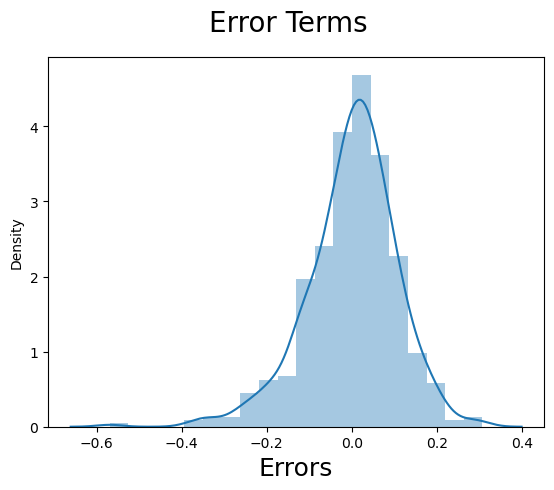

In [92]:
y_train_pred = final_lr_model.predict(X_train_rfe)
res = y_train - y_train_pred
fig = plt.figure()
sns.distplot(res, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)

Based on the above plot we can conclude that the error is normally distributed

## Step 5 : Prediction and evaluation on test data

### Make Prediction

In [93]:
# Applying the scaling on the test sets
bike_testset_df[num_vars] = scaler.transform(bike_testset_df[num_vars])

#Dividing into X and Y sets for the model building
y_test = bike_testset_df.pop('count')
X_test = bike_testset_df

# Drop columns that we eliminated while create the models
X_test_sm = X_test[final_lr_columns]

# Add a constant
X_test_sm = sm.add_constant(X_test_sm)

# Making predictions
y_test_pred = final_lr_model.predict(X_test_sm)

### Model Evaluation

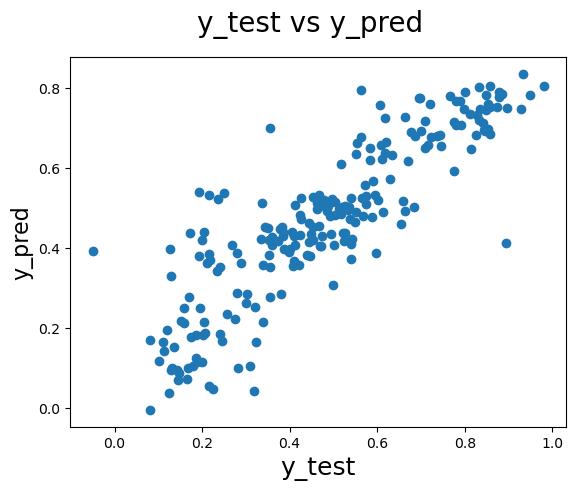

In [94]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16) 
plt.show()

### R2 value calculation for bike_test dataframe

In [95]:
r2 = round(r2_score(y_test, y_test_pred),4)
r2

0.7492